# Time series prediction with LSTM (student notebook)

Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables.

This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems.

In this lab, you will discover how you can develop an LSTM model for multivariate time series forecasting with the Keras deep learning library.

In [1]:
"""
(Practical tip) Table of contents can be compiled directly in jupyter notebooks using the following code:
I set an exception: if the package is in your installation you can import it otherwise you download it 
then import it.
"""
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
"""
Output Table of contents to navigate easily in the notebook. 
For interested readers, the package also includes Ipython magic commands to go back to this cell
wherever you are in the notebook to look for cells faster
"""
add_notebook_menu()

## Imports

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import matplotlib.pyplot as plt

import math
import numpy as np 
import pandas as pd

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, AveragePooling1D, RepeatVector
from tensorflow.keras import utils

## LSTM network for uni-variate time series

LSTM can be used to model univariate time series forecasting problems.

These problems consist of a single set of observations and a model is needed to learn from the past set of observations in order to forecast the next value in the sequence.

We will demonstrate a number of variations of the LSTM model for univariate time series forecasting.

Be careful not to draw hasty conclusions about the relative performance of the models. The number of layers or neurons are highly variable between models.

### Data preparation

#### A first example

Consider a given univariate sequence: `[10, 20, 30, 40, 50, 60, 70, 80, 90]`

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

`X,				y
10, 20, 30		40
20, 30, 40		50
30, 40, 50		60
...`

The `series_to_supervised()` function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps (`n_in, by default 3`) and the output has also a specified number of time steps (`n_out, by default 1`).

By default, the data to predict is the last columns.

In [6]:
def series_to_supervised(data, n_in=3, n_out=1, output=None, dropnan=True):
    output =  [data.columns[-1]] if output is None else output
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols += [df.shift(i)]
        names += [('%s(t-%d)' % (j, i)) for j in data.columns]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols += [df[output].shift(-i)]
        if i == 0:
            names += [('%s(t)' % (j)) for j in output]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in output]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

<font color='red'>
$TO DO - Students$

* create the time series mentioned in the first exemple.
</font>

In [7]:
# my_time_series =  pd.DataFrame(data = [10, 20, 30, 40, 50, 60, 70, 80, 90])
# first convert the list to a dataframe..
my_time_series = pd.DataFrame(data=[int(10*i) for i in range(10)])

In [8]:
data = series_to_supervised(my_time_series, n_in = 3, n_out= 1) # create the dataframe 
data.head() # show the first 5 rows of the dataframe

,0(t-3),0(t-2),0(t-1),0(t)
3,0.0,10.0,20.0,30
4,10.0,20.0,30.0,40
5,20.0,30.0,40.0,50
6,30.0,40.0,50.0,60
7,40.0,50.0,60.0,70


<font color='blue'>
    <bold>Head of the previous dataset</bold>

`	0(t-3)	0(t-2)	0(t-1)	0(t)
3	0.0	10.0	20.0	30
4	10.0	20.0	30.0	40
5	20.0	30.0	40.0	50
6	30.0	40.0	50.0	60
7	40.0	50.0	60.0	70
`
</font>

#### Do the same for a more sophisticated series

In [9]:
SIZE = 250
time_stamps = range(SIZE)

fct = lambda x: x*math.sin(x)
time_series = pd.DataFrame(data={"data":[fct(x) for x in range(SIZE)]})
n_features = my_time_series.shape[1] # for univariate time series

<font color='red'>
$TO DO - Students$

* Plot the time series generated thanks to x --> x*sin(x) with 250 timestamps
* label x and y axis
</font>

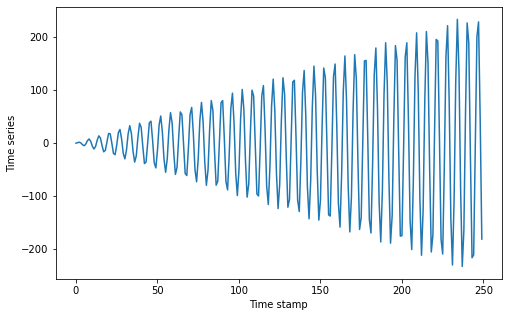

In [10]:
""" FILL """
# plot the timeStamp according to the time series
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))

ax1.plot(time_series, label="Time series")
plt.xlabel('Time stamp') # x label
plt.ylabel('Time series') # Y label
plt.show()

<font color='red'>
$TO DO - Students$

* Using `series_to_supervise` split data into samples with n_in = 6 and n_out = 1
* Put the result in variable data
</font>

In [11]:
""" FILL """
n_in = 6 
n_out = 1
data = series_to_supervised(time_series, n_in, n_out) # build the dataframe using another in and out 
data.head()

,data(t-6),data(t-5),data(t-4),data(t-3),data(t-2),data(t-1),data(t)
6,0.000000,0.841471,1.818595,0.423360,-3.027210,-4.794621,-1.676493
7,0.841471,1.818595,0.423360,-3.027210,-4.794621,-1.676493,4.598906
8,1.818595,0.423360,-3.027210,-4.794621,-1.676493,4.598906,7.914866
9,0.423360,-3.027210,-4.794621,-1.676493,4.598906,7.914866,3.709066
10,-3.027210,-4.794621,-1.676493,4.598906,7.914866,3.709066,-5.440211


<font color='blue'>
    <bold>Head of the previous dataset</bold>

`data(t-6)	data(t-5)	data(t-4)	data(t-3)	data(t-2)	data(t-1)	data(t)
6	0.000000	0.841471	1.818595	0.423360	-3.027210	-4.794621	-1.676493
7	0.841471	1.818595	0.423360	-3.027210	-4.794621	-1.676493	4.598906
8	1.818595	0.423360	-3.027210	-4.794621	-1.676493	4.598906	7.914866
9	0.423360	-3.027210	-4.794621	-1.676493	4.598906	7.914866	3.709066
10	-3.027210	-4.794621	-1.676493	4.598906	7.914866	3.709066	-5.440211
`
</font>

Contrary to the approaches used so far, we cannot separate the data into TRAIN, VALID and TEST in a random way, since we are dealing with time series where the order is important.

The TRAIN data will therefore necessarily be at the beginning, then we will find the VALIDATION data and finally the TEST data.

Here are the chosen indices.

In [12]:
testAndValid = 0.1

SPLIT = int(testAndValid*len(data))
idx_train = len(data)-2*SPLIT
idx_test = len(data)-SPLIT

print("TRAIN=time_series[:"+str(idx_train)+"]")
print("VALID=time_series["+str(idx_train)+":"+str(idx_test)+"]")
print("TEST=time_series["+str(idx_test)+":]")

TRAIN=data[:idx_train]
VAL=data[idx_train:idx_test]
TEST=data[idx_test:]

TRAIN=time_series[:196]
VALID=time_series[196:220]
TEST=time_series[220:]


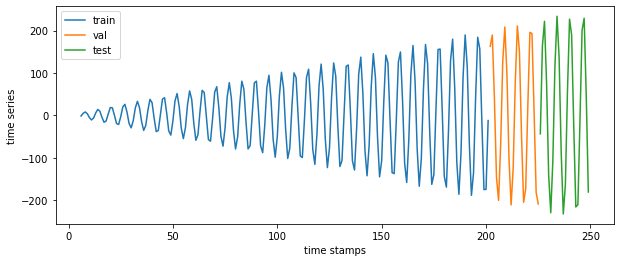

In [13]:
# access the data data(t) column
plt.figure(figsize=(10, 4))
plt.plot(TRAIN['data(t)'], label="train") # add the training data to the plot with train label 
plt.plot(VAL['data(t)'], label="val") # add the validation data to the plot with val label
plt.plot(TEST['data(t)'], label="test") # add the test data to the plot with test label
plt.legend() # Add the legend to the plot
plt.xlabel("time stamps");
plt.ylabel("time series");

<font color='red'>
$TO DO - Students$

* complete the code for preprocessing your train/validation/test datasets.
</font>

In [14]:
# split into input and outputs
train_X, train_y = TRAIN.values[:, :-n_out], TRAIN.values[:, -n_out] # get x and y train
val_X, val_y = VAL.values[:, :-n_out], VAL.values[:, -n_out] # get x and y val
test_X, test_y = TEST.values[:, :-n_out], TEST.values[:, -n_out] # get x and y test

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((-1, n_in, n_features)) # reshape the x train
val_X = val_X.reshape((-1, n_in, n_features)) # reshape the x val
test_X = test_X.reshape((-1, n_in, n_features)) # reshape the x test

train_X.shape, train_y.shape

((196, 6, 1), (196,))

<font color='blue'>
<bold>
train_X.shape = (196, 6, 1)

train_y.shape = (196,)
</font>

### Build a first network using LSTM cells
<br>
<font color='red'>
$TO DO - Students$

* Look carefully at the following cell
* What is the impact of the `return_sequences` parameter of the LSTM cell? (change the value: False or True and observe the shape of the output).
</font>

In [15]:
LSTM_SIZE = 16

inputs = Input(shape=(n_in, n_features)) # define the input
hidden = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs) # last hidden layer the return sequence ,must be false
outputs = Dense(n_out, activation='linear')(hidden) # define the output
model = Model(inputs=inputs, outputs=outputs) # define the model
model.summary() # model summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


<font color='red'>
$TO DO - Students$

* Complete the function build_and_fit used to train your RNN model.
* compile : as usual
* fit : as usual but...
    * Be careful, you have to set the shuffle parameter to false in order to take the data in order.
    * Use the validation set to control the overfitting in the earlystopping callback
</font>

In [16]:
def build_and_fit(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # compile the model with mae loss and adam optimizer 
    model.compile(loss='mae', metrics=["mae"], optimizer='adam')
    # define early stopping with patience of 20, code taken from previous lab
    es = EarlyStopping(monitor='val_mae', min_delta=0.005, patience=20,
                                verbose=2, mode='min', restore_best_weights=True) 
    # fit the model and save it to an history 
    history = model.fit(X_train, y_train, validation_data = (X_val,y_val), callbacks=[es],
                    batch_size=32, epochs=20) 
    y_pred = model.predict(X_test) # ypred by predicting x_test 
    # plot history
    plt.figure(figsize=(20,8))
    plt.subplot(331)
    plt.plot(history.history['loss'][3:], label='loss')
    plt.plot(history.history['val_loss'][3:], label='val_loss')
    plt.legend()
    plt.subplot(332)
    plt.plot(history.history['mae'][3:], label='mae')
    plt.plot(history.history['val_mae'][3:], label='val_mae')
    plt.legend()
    plt.subplot(333)
    plt.plot(range(len(y_train)), y_train, label="train")
    plt.plot(range(len(y_train), len(y_train)+len(y_val)), y_val, label="valid")
    plt.plot(range(len(y_train)+len(y_val), len(y_train)+len(y_val)+len(y_pred)), y_test, label="test")
    plt.plot(range(len(y_train)+len(y_val), len(y_train)+len(y_val)+len(y_pred)), y_pred, label="predict")
    plt.legend(loc='center left')
    plt.show()
    
    return model

Epoch 1/20
7/7 [==============================] - 1s 42ms/step - loss: 64.7803 - mae: 64.7803 - val_loss: 135.3417 - val_mae: 135.3417
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 63.9387 - mae: 63.9387 - val_loss: 133.6281 - val_mae: 133.6281
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 63.1539 - mae: 63.1539 - val_loss: 132.1020 - val_mae: 132.1020
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 62.1652 - mae: 62.1652 - val_loss: 129.5654 - val_mae: 129.5654
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 60.5182 - mae: 60.5182 - val_loss: 123.4751 - val_mae: 123.4751
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 57.5405 - mae: 57.5405 - val_loss: 115.0925 - val_mae: 115.0925
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 53.9954 - mae: 53.9954 - val_loss: 108.3321 - val_mae: 108.3321
Epoch 8/20
7/7 [==============================] - 0s 8ms/step

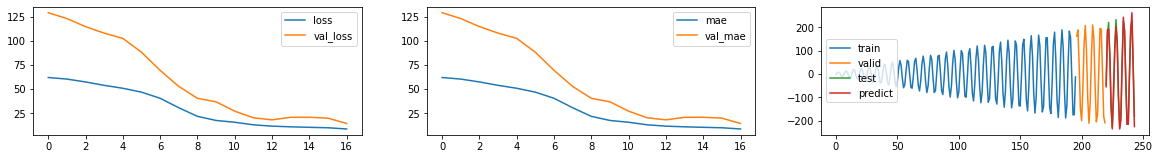

In [17]:
model = build_and_fit(model, train_X, train_y, val_X, val_y, test_X, test_y) # create the model

In [18]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-3.8604667]] 324


### Stacked Bi-LSTM

In order to improve the performance of the model, it's possible to:
- stack LSTM with `return_sequence=True` for all levels except the last one where `return_sequence=False`
- use Bi-LSTM

<font color='red'>
$TO DO - Students$

* Build a model stacking 3 BI-LSTM layers 
</font>

In [19]:
inputs = Input(shape=(n_in, n_features), name="input", dtype=tf.float32) # input layer
" FILL hidden 1"
x1 = (Bidirectional(LSTM(LSTM_SIZE, return_sequences=True,activation='relu')))(inputs) # 1st hidden layer
" FILL hidden 2"
x2 = (Bidirectional(LSTM(LSTM_SIZE, return_sequences=True,activation='relu')))(x1) # 2nd hidden layer
" FILL hidden 3"
x3 = (Bidirectional(LSTM(LSTM_SIZE, return_sequences=False,activation='relu')))(x2) #last one must be false. explained above

outputs = Dense(n_out, activation='linear', name="output")(x3) # define the output

model = Model(inputs=inputs, outputs=outputs) # define the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 32)            2304      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 32)            6272      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 output (Dense)              (None, 1)                 33        
                                                           

Epoch 1/20
7/7 [==============================] - 5s 101ms/step - loss: 65.0044 - mae: 65.0044 - val_loss: 136.9533 - val_mae: 136.9533
Epoch 2/20
7/7 [==============================] - 0s 15ms/step - loss: 63.2911 - mae: 63.2911 - val_loss: 131.8848 - val_mae: 131.8848
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 60.0640 - mae: 60.0640 - val_loss: 121.3245 - val_mae: 121.3245
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 54.6813 - mae: 54.6813 - val_loss: 101.6020 - val_mae: 101.6020
Epoch 5/20
7/7 [==============================] - 0s 16ms/step - loss: 45.7790 - mae: 45.7790 - val_loss: 72.7827 - val_mae: 72.7827
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 31.6759 - mae: 31.6759 - val_loss: 53.3525 - val_mae: 53.3525
Epoch 7/20
7/7 [==============================] - 0s 16ms/step - loss: 20.2992 - mae: 20.2992 - val_loss: 43.5753 - val_mae: 43.5753
Epoch 8/20
7/7 [==============================] - 0s 16ms/st

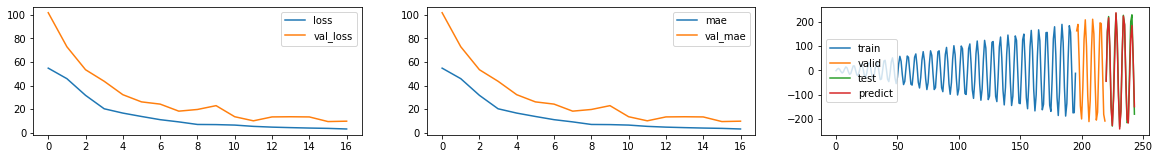

In [20]:
model = build_and_fit(model, train_X, train_y, val_X, val_y, test_X, test_y) 

In [21]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-14.564305]] 324


## LSTM network for multi-variate time series 

Multivariate time series data means data where there is more than one observation for each time step.

There are two main models we may need with multivariate time series data. These are the multiple input series or the multiple parallel series depending on whether we want to predict one or more of the variables.

In this notebook, we focus on the first case: as input, several time series and as output (the prediction), a single time series.

### Prepare the data

We reuse the same `series_to_supervise()` function in order to build a dataset with :
* n_in elements for each series
* n_out elements for each series to be predict

You have also to select one (Multiple Input Series) or many time series (Multiple Parallel Series) to predict.

In [22]:
# Get the time series
fct2 = lambda x: 2*x
time_series1 = [fct(x) for x in range(SIZE)]
time_series2 = [fct2(x) for x in range(SIZE)]
out_seq = [time_series1[i]+time_series2[i] for i in range(SIZE)]

In [23]:
# Get the dataset
dataset = pd.DataFrame(data={"f1":time_series1, "f2":time_series2, "output":out_seq}, index=range(SIZE))
n_features = dataset.shape[1] # for multivariate time series
dataset.head()

,f1,f2,output
0,0.000000,0,0.000000
1,0.841471,2,2.841471
2,1.818595,4,5.818595
3,0.423360,6,6.423360
4,-3.027210,8,4.972790


As with the univariate time series, we must structure these data into samples with input and output elements.
An LSTM model needs sufficient context to learn a mapping from an input sequence to an output value. LSTMs can support parallel input time series as separate variables or features. Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

If we chose six input time steps for the three features, we have to transform the dataset in the following way.

In [24]:
# As previously, prepare the dataset
''' In the followig example, we select 
- n_in number of time steps (6)
- n_out number of time steps of output
- and one serie to predict : output
'''
n_features = dataset.shape[1] # for multivariate time series
n_in = 6
n_out = 1
output = ["output"]

data = series_to_supervised(dataset, n_in, n_out, output=output) # create the dataset..
data.head()

,f1(t-6),f2(t-6),output(t-6),f1(t-5),f2(t-5),output(t-5),f1(t-4),f2(t-4),output(t-4),f1(t-3),f2(t-3),output(t-3),f1(t-2),f2(t-2),output(t-2),f1(t-1),f2(t-1),output(t-1),output(t)
6,0.000000,0.0,0.000000,0.841471,2.0,2.841471,1.818595,4.0,5.818595,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,10.323507
7,0.841471,2.0,2.841471,1.818595,4.0,5.818595,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,18.598906
8,1.818595,4.0,5.818595,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,4.598906,14.0,18.598906,23.914866
9,0.423360,6.0,6.423360,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,4.598906,14.0,18.598906,7.914866,16.0,23.914866,21.709066
10,-3.027210,8.0,4.972790,-4.794621,10.0,5.205379,-1.676493,12.0,10.323507,4.598906,14.0,18.598906,7.914866,16.0,23.914866,3.709066,18.0,21.709066,14.559789


In [25]:
# Split dataset into TRAIN, VAL and TEST
testAndValid = 0.1

SPLIT = int(testAndValid*len(data))
idx_train = len(data)-2*SPLIT
idx_test = len(data)-SPLIT

print("TRAIN=time_series[:"+str(idx_train)+"]")
print("VALID=time_series["+str(idx_train)+":"+str(idx_test)+"]")
print("TEST=time_series["+str(idx_test)+":]")

TRAIN=data[:idx_train]
VAL=data[idx_train:idx_test]
TEST=data[idx_test:]

TRAIN=time_series[:196]
VALID=time_series[196:220]
TEST=time_series[220:]


<font color='red'>
$TO DO - Students$

* build train_X, val_X, test_X and train_y, val_y and test_y as before. Then print the shapes of tensors
    * train_X is a 3D-tensor (196, 6, 3) for me
    * train_y is a 1D-tensor (196,)
</font>

In [26]:
""" FILL """
# split into input and outputs
train_X, train_y = TRAIN.values[:, :-n_out], TRAIN.values[:, -n_out]
val_X, val_y = VAL.values[:, :-n_out], VAL.values[:, -n_out]
test_X, test_y = TEST.values[:, :-n_out], TEST.values[:, -n_out]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((-1, n_in, n_features))
val_X = val_X.reshape((-1, n_in, n_features))
test_X = test_X.reshape((-1, n_in, n_features))

train_X.shape, train_y.shape

((196, 6, 3), (196,))

### Build a neuronal model

Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional. It's also possible to use CNN or mixed CNN and LSTM.

We will use a Vanilla LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument.

In [27]:
inputs = Input(shape=(n_in, n_features))
hidden = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs)
outputs = Dense(n_out, activation='linear')(hidden)
model = Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 3)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 16)                1280      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
7/7 [==============================] - 1s 33ms/step - loss: 64.7979 - mae: 64.7979 - val_loss: 124.5526 - val_mae: 124.5526
Epoch 2/20
7/7 [==============================] - 0s 9ms/step - loss: 55.5147 - mae: 55.5147 - val_loss: 107.1478 - val_mae: 107.1478
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 51.4630 - mae: 51.4630 - val_loss: 108.9417 - val_mae: 108.9417
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 49.2012 - mae: 49.2012 - val_loss: 106.4544 - val_mae: 106.4544
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 45.5796 - mae: 45.5796 - val_loss: 93.1042 - val_mae: 93.1042
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 41.8547 - mae: 41.8547 - val_loss: 81.4368 - val_mae: 81.4368
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 38.8037 - mae: 38.8037 - val_loss: 78.2912 - val_mae: 78.2912
Epoch 8/20
7/7 [==============================] - 0s 8ms/step - los

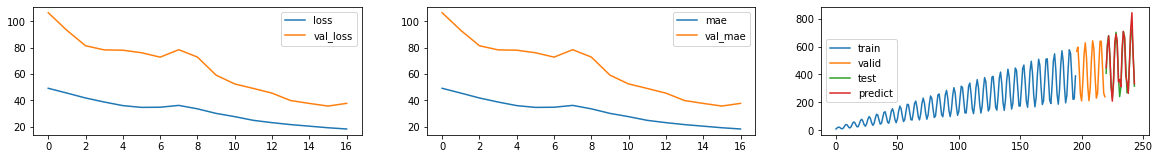

In [28]:
model = build_and_fit(model, train_X, train_y, val_X, val_y, test_X, test_y)

## Lab work: Air Pollution Forecasting

This is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.

The data includes the date-time, the pollution called PM2.5 concentration, and the weather information including dew point, temperature, pressure, wind direction, wind speed and the cumulative number of hours of snow and rain. The complete feature list in the raw data is as follows:

1. No: row number
1. year: year of data in this row
1. month: month of data in this row
1. day: day of data in this row
1. hour: hour of data in this row
1. pm2.5: PM2.5 concentration
1. DEWP: Dew Point
1. TEMP: Temperature
1. PRES: Pressure
1. cbwd: Combined wind direction
1. Iws: Cumulated wind speed
1. Is: Cumulated hours of snow
1. Ir: Cumulated hours of rain

We can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

This dataset can be used to frame other forecasting problems.

## Load the data

In [29]:
DATAPATH = "https://www.i3s.unice.fr/~riveill/dataset/pollution.csv"

In [30]:
# Read the dataset
data = pd.read_csv(DATAPATH, sep=",", header=0, index_col=0)
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


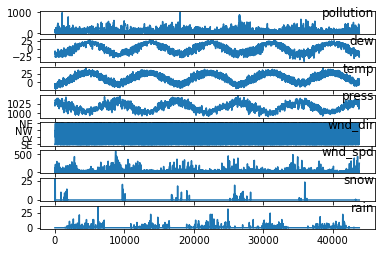

In [31]:
plt.figure()
for i, column in enumerate(data.columns):
    plt.subplot(len(data.columns), 1, i+1)
    plt.plot(data[column].to_numpy())
    plt.title(column, y=0.5, loc='right')
plt.show()

### Construct the dataset

The first step is to prepare the pollution dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution at the current hour (t) given the pollution measurement and weather conditions at the prior time step.

In [32]:
n_features = data.shape[1] # for multivariate time series
n_in = 6
n_out = 1
output = ["pollution"]

n_features

8

<font color='red'>
$TO DO - Students$

* using `series_to_supervised` function build the dataset
</font>

In [33]:
dataset = series_to_supervised(data, n_in, n_out, output=output)
dataset.head()

,pollution(t-6),dew(t-6),temp(t-6),press(t-6),wnd_dir(t-6),wnd_spd(t-6),snow(t-6),rain(t-6),pollution(t-5),dew(t-5),...,rain(t-2),pollution(t-1),dew(t-1),temp(t-1),press(t-1),wnd_dir(t-1),wnd_spd(t-1),snow(t-1),rain(t-1),pollution(t)
date,,,,,,,,,,,,,,,,,,,,,
2010-01-02 06:00:00,129.0,-16.0,-4.0,1020.0,SE,1.79,0.0,0.0,148.0,-15.0,...,0.0,109.0,-7.0,-6.0,1022.0,SE,7.14,3.0,0.0,105.0
2010-01-02 07:00:00,148.0,-15.0,-4.0,1020.0,SE,2.68,0.0,0.0,159.0,-11.0,...,0.0,105.0,-7.0,-6.0,1023.0,SE,8.93,4.0,0.0,124.0
2010-01-02 08:00:00,159.0,-11.0,-5.0,1021.0,SE,3.57,0.0,0.0,181.0,-7.0,...,0.0,124.0,-7.0,-5.0,1024.0,SE,10.72,0.0,0.0,120.0
2010-01-02 09:00:00,181.0,-7.0,-5.0,1022.0,SE,5.36,1.0,0.0,138.0,-7.0,...,0.0,120.0,-8.0,-6.0,1024.0,SE,12.51,0.0,0.0,132.0
2010-01-02 10:00:00,138.0,-7.0,-5.0,1022.0,SE,6.25,2.0,0.0,109.0,-7.0,...,0.0,132.0,-7.0,-5.0,1025.0,SE,14.30,0.0,0.0,140.0


In [34]:
dataset.dtypes

pollution(t-6)    float64
dew(t-6)          float64
temp(t-6)         float64
press(t-6)        float64
wnd_dir(t-6)       object
wnd_spd(t-6)      float64
snow(t-6)         float64
rain(t-6)         float64
pollution(t-5)    float64
dew(t-5)          float64
temp(t-5)         float64
press(t-5)        float64
wnd_dir(t-5)       object
wnd_spd(t-5)      float64
snow(t-5)         float64
rain(t-5)         float64
pollution(t-4)    float64
dew(t-4)          float64
temp(t-4)         float64
press(t-4)        float64
wnd_dir(t-4)       object
wnd_spd(t-4)      float64
snow(t-4)         float64
rain(t-4)         float64
pollution(t-3)    float64
dew(t-3)          float64
temp(t-3)         float64
press(t-3)        float64
wnd_dir(t-3)       object
wnd_spd(t-3)      float64
snow(t-3)         float64
rain(t-3)         float64
pollution(t-2)    float64
dew(t-2)          float64
temp(t-2)         float64
press(t-2)        float64
wnd_dir(t-2)       object
wnd_spd(t-2)      float64
snow(t-2)   

<font color='blue'>
<bold>dataset.dtypes gives the following result for me</bold>

<pre>
pollution(t-6)    float64
dew(t-6)          float64
temp(t-6)         float64
press(t-6)        float64
wnd_dir(t-6)       object
wnd_spd(t-6)      float64
snow(t-6)         float64
rain(t-6)         float64
pollution(t-5)    float64
dew(t-5)          float64
temp(t-5)         float64
press(t-5)        float64
wnd_dir(t-5)       object
wnd_spd(t-5)      float64
snow(t-5)         float64
rain(t-5)         float64
pollution(t-4)    float64
dew(t-4)          float64
temp(t-4)         float64
press(t-4)        float64
wnd_dir(t-4)       object
wnd_spd(t-4)      float64
snow(t-4)         float64
rain(t-4)         float64
pollution(t-3)    float64
dew(t-3)          float64
temp(t-3)         float64
press(t-3)        float64
wnd_dir(t-3)       object
wnd_spd(t-3)      float64
snow(t-3)         float64
rain(t-3)         float64
pollution(t-2)    float64
dew(t-2)          float64
temp(t-2)         float64
press(t-2)        float64
wnd_dir(t-2)       object
wnd_spd(t-2)      float64
snow(t-2)         float64
rain(t-2)         float64
pollution(t-1)    float64
dew(t-1)          float64
temp(t-1)         float64
press(t-1)        float64
wnd_dir(t-1)       object
wnd_spd(t-1)      float64
snow(t-1)         float64
rain(t-1)         float64
pollution(t)      float64
dtype: object
<pre>
</font>

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. 

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [35]:
# get the values
values = dataset.values

# split into train and test sets
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
val = values[n_train_hours:2*n_train_hours, :]
test = values[2*n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-n_out], np.array(train[:, -n_out], dtype="float64")
val_X, val_y = val[:, :-n_out], np.array(val[:, -n_out], dtype="float64")
test_X, test_y = test[:, :-n_out], np.array(test[:, -n_out], dtype="float64")

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
val_X = val_X.reshape((val_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
train_X.shape, train_y.shape

((8760, 6, 8), (8760,))

### Encode and normalize dataset

Data encoding and normalization
* The wind direction feature is label encoded (integer encoded).
* All features are normalized

And then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

In [36]:
numeric_features = [i for i, t in enumerate(dataset.dtypes[:-n_out]) if t in ['float64', 'int32']]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = [i for i in range(len(dataset.columns)-n_out) if i not in numeric_features]
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

train_X_enc = preprocessor.fit_transform(train_X.reshape(len(train_X), -1)).reshape(len(train_X), n_in, -1)
val_X_enc = preprocessor.fit_transform(val_X.reshape(len(val_X), -1)).reshape(len(val_X), n_in, -1)
test_X_enc = preprocessor.transform(test_X.reshape(len(test_X), -1)).reshape(len(test_X), n_in, -1)
                                                                                    
n_features = train_X_enc.shape[2] # Change with oneHotEncode
n_features

11

Running the code below prepare the data. Executing the next cell, prints the first 5 rows of the transformed dataset. We can see the 8 input variables (input series) and the 1 output variable (pollution level at the current hour).

### Build, Compile, Fit, Predict and Evaluate a model
<br>
<font color='red'>
$TO DO - Students$

* Build your model
    * Put the number of hidden layers you want. If possible more than one.
</font>

In [37]:
LSTM_SIZE = 16
# explained in previous cells
inputs = Input(shape=(n_in, n_features)) 
hidden = LSTM(LSTM_SIZE, return_sequences=True, activation='relu')(inputs)
hidden1 = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(hidden)
outputs = Dense(n_out, activation='linear')(hidden1)
model = Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 11)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 6, 16)             1792      
                                                                 
 lstm_6 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


<font color='red'>
$TO DO - Students$

* Compile your model
</font>

In [38]:
# Compile the model
model.compile(loss='mae', metrics=["mae"], optimizer='adam')

In [39]:
train_y

array([105., 124., 120., ...,  19.,  18.,  17.])

<font color='red'>
$TO DO - Students$

* Fit your model using `EarlyStopping`
</font>

In [40]:
# Early stopping
es = EarlyStopping(monitor='val_mae', min_delta=0.005, patience=20,
                                verbose=2, mode='min', restore_best_weights=True)
# fit the model and save it to the historyh
history = model.fit(train_X_enc, train_y, validation_data = (val_X_enc,val_y), callbacks=[es],
                    batch_size=32, epochs=20)

Epoch 1/20
274/274 [==============================] - 3s 7ms/step - loss: 65.4177 - mae: 65.4177 - val_loss: 33.3115 - val_mae: 33.3115
Epoch 2/20
274/274 [==============================] - 2s 6ms/step - loss: 29.8629 - mae: 29.8629 - val_loss: 25.1943 - val_mae: 25.1943
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 24.5238 - mae: 24.5238 - val_loss: 23.1780 - val_mae: 23.1780
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 22.1159 - mae: 22.1159 - val_loss: 21.5053 - val_mae: 21.5053
Epoch 5/20
274/274 [==============================] - 2s 6ms/step - loss: 20.6223 - mae: 20.6223 - val_loss: 19.6912 - val_mae: 19.6912
Epoch 6/20
274/274 [==============================] - 2s 6ms/step - loss: 19.0916 - mae: 19.0916 - val_loss: 17.7578 - val_mae: 17.7578
Epoch 7/20
274/274 [==============================] - 2s 6ms/step - loss: 18.1946 - mae: 18.1946 - val_loss: 17.5261 - val_mae: 17.5261
Epoch 8/20
274/274 [============================

<font color='red'>
$TO DO - Students$

* Plot learning curve
</font>

<AxesSubplot:>

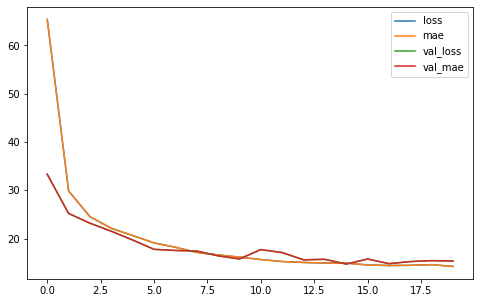

In [41]:
""" PLOT """
# plot the learning curve.. code taken from the previous lab
pd.DataFrame(history.history).plot(figsize=(8,5))

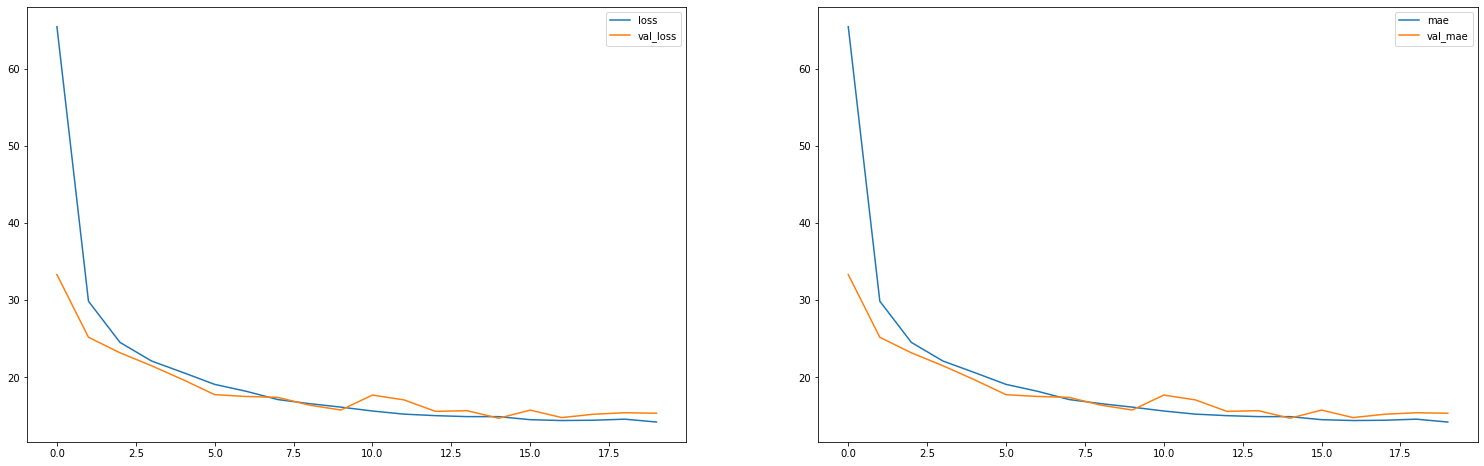

In [42]:

# plot the learning curve separetly.. code taken from the previous lab
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,8))

ax1.plot(history.history['loss'], label="loss")
ax1.plot(history.history['val_loss'], label="val_loss")
ax1.legend()
ax2.plot(history.history['mae'], label="mae")
ax2.plot(history.history['val_mae'], label="val_mae")
ax2.legend()
plt.show()

<font color='red'>
$TO DO - Students$

* Use your model to predict test set data
</font>

In [43]:
# make a prediction
pred = model.predict(test_X_enc)
pred

array([[105.381615],
       [107.22347 ],
       [107.231804],
       ...,
       [ 18.147974],
       [ 18.862795],
       [ 18.528479]], dtype=float32)

<font color='red'>
$TO DO - Students$

* Evaluate your model with RMSA
</font>

In [44]:
# # calculate RMSE

# import tensorflow as tf
# import tensorflow.keras.backend as K


# msle = tf.keras.losses.MeanSquaredLogarithmicError()
# rmse = K.sqrt(msle(test_y, pred)) 

# # rmse = model.rmse
# 'Test RMSE: %.3f' % rmse

In [45]:
# calculate RMSE
from math import sqrt
rmse = sqrt(mean_squared_error(test_y,pred)) # y_true = y_test
rmse =rmse/100
'Test RMSE: %.3f' % rmse

'Test RMSE: 0.274'

### Predict next day

Generally, what we are trying to predict is a pollution indicator for the day or per 12-hour period. 

Modify the datasets to create a new column giving a pollution indicator per half day: little pollution, moderate pollution, heavy pollution.

In [46]:
data.head(10)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,SE,7.14,3,0
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,SE,8.93,4,0
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,SE,10.72,0,0
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,SE,12.51,0,0


In [47]:
data['pollution'].describe() , data['pollution'].median()

(count    43800.000000
 mean        94.013516
 std         92.252276
 min          0.000000
 25%         24.000000
 50%         68.000000
 75%        132.250000
 max        994.000000
 Name: pollution, dtype: float64,
 68.0)

In [48]:
# fct to add the pollution indicator column 
def label_race (row):
   if row['pollution'] >0 and row['pollution'] <24:
      return 'little pollution'
   if row['pollution'] >=24 and row['pollution'] <132:
      return 'moderate pollution'
   if row['pollution'] >=132:
      return 'heavy pollution'
   
   return 'Other'

In [49]:
# add the polution indicator column
data['polution_indicator'] = data.apply (lambda row: label_race(row), axis=1)

In [50]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,polution_indicator
date,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,moderate pollution
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,heavy pollution
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,heavy pollution
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,heavy pollution
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,heavy pollution
